In [1]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy


## Convenience functions

### Reduced parameters

In [604]:
def encode_xy_tele_1d(kon,koff,kinit,beta):
    kappa = kon+koff
    K_avg = kon*kinit/kappa
    x = kappa/(kappa+beta)
#     y = kinit/(kinit+kon)
    THETA_ = kon*kappa/(koff*kinit)
    y = 1/(1+THETA_)
    return x,y,K_avg,beta

def encode_xy_sde_1d(a,kappa,theta,beta):
    K_avg = a*theta/kappa
    x = kappa/(kappa+beta)
    y = theta/(theta+a)
    return x,y,K_avg,beta

def decode_xy_tele_1d(x, y, K_avg, beta):
    kappa = (beta)*(x/(1-x))
    THETA_ = 1/y - 1
    C = K_avg*THETA_
    koff = (C+2*kappa-np.sqrt(C**2+4*C*kappa))/2
    kon = kappa-koff
    kinit = K_avg * kappa / kon
    return kon,koff,kinit, beta
def decode_xy_sde_1d(x, y, K_avg, beta):
    kappa = (beta)*(x/(1-x))
    a_over_th = 1/y - 1
    theta = np.sqrt(kappa*K_avg/a_over_th)
    a = K_avg*kappa/theta
    return a, kappa, theta, beta


In [576]:
# decode_xy_tele_1d??

In [543]:
def encode_xy_tele_2d(kon,koff,kinit,beta,gamma):
    kappa = kon+koff
    K_avg = kon*kinit/kappa
    x = kappa/(kappa+beta)
#     y = kinit/(kinit+kon)
    theta = kon*kappa/(koff*kinit)
    y = theta/(theta+kon)
    return x,y,K_avg,beta,gamma

def encode_xy_sde_2d(a,kappa,theta,beta,gamma):
    K_avg = a*theta/kappa
    x = kappa/(kappa+beta)
    y = theta/(theta+a)
    return x,y,K_avg,beta,gamma

def decode_xy_tele_2d(x,y,K_avg,beta,gamma):
    kappa = (beta + gamma)*(x/(1-x))
    a_over_th = 1/y - 1
    theta = np.sqrt(kappa*K_avg/a_over_th)
    a = K_avg*kappa/theta
    kon = a
    theta = kinit
    koff = kappa-kon
    return kon,koff,kinit,beta,gamma

def decode_xy_sde_2d(x, y, K_avg, beta,gamma):
    kappa = (beta + gamma)*(x/(1-x))
    a_over_th = 1/y - 1
    theta = np.sqrt(kappa*K_avg/a_over_th)
    a = K_avg*kappa/theta
    return a,kappa,theta,beta,gamma


### The switching model

In [906]:
class TelegraphModel():
    """
    This collection of convenience functions is placed in its own class mostly to avoid function name conflicts.
    The code is largely reused from "Transient and delay chemical master equations".
    """
    def __init__(self):
        pass
    def setup(self,N,n,K_val,A_val,beta_val,gamma_val):
        H = np.zeros((N,N))
        for kv in K_val:
            H[kv[0],kv[1]] = kv[2]
        H -= np.diag(H.sum(1))

        A = np.zeros((N,n))
        for av in A_val:
            A[av[0],av[1]-1] = av[2]

        B = np.zeros((n,n))
        for bv in beta_val:
            B[bv[0]-1,bv[1]-1] = bv[2]
        B -= np.diag(B.sum(1))
        for gv in gamma_val:
            B[gv[0]-1,gv[0]-1] -= gv[1]

        Nspec = N+n
        Nrxn = len(K_val) + len(A_val) + len(gamma_val) + len(beta_val)
        Hss = scipy.linalg.null_space(H.T)
        Hss /= Hss.sum()
        Hss = Hss.squeeze()
        return H,A,B,Hss

    def get_g(self,limits):
        u = []
        mx = np.copy(limits)
        mx[-1] = mx[-1] // 2 + 1

        for i in range(len(mx)):
            l = np.arange(mx[i])
            u_ = np.exp(-2j*np.pi*l/limits[i])-1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
        for i in range(len(mx)):
            g[i] = g[i].flatten()
        return np.asarray(g).T,mx

    def compute_coeff(self,L,V,Vinv,u,j=0):
        n_u = u.shape[1]
        a = np.asarray([(V@np.diag( Vinv @ u[:,i]))[j] for i in range(n_u)]).T
        return a

    def compute_eigs(self,C):
        L,V = np.linalg.eig(C)
        Vinv = np.linalg.inv(V)
        return L,V,Vinv

    def pss_wrapper(self,H,A,C,t,mx,n,N,initcond):
        g,mx_red = self.get_g(mx)
        L,V,Vinv = self.compute_eigs(C)
        coeff = np.asarray([self.compute_coeff(L,V,Vinv,g.T,i) for i in range(n)])

        if initcond[0][0]=='thermalized':
            Hfin = scipy.linalg.null_space(H.T)
            Hfin /= Hfin.sum()
            w = Hfin.squeeze()
        elif initcond[0][0]=='deterministic':
            w = np.zeros(N)
            w[initcond[0][1]] = 1
        elif initcond[0][0]=='categorical':
            w = initcond[0][1]
        else:
            raise ValueError('Not implemented')
        w = np.asarray(w,dtype=np.complex128)

        gf_initcond_prop = np.matlib.repmat(w,g.shape[0],1).astype(np.complex128)
        gf = self.gfun_numerical(g,t,H,A,N,L,coeff,gf_initcond_prop)
        gf = np.reshape(gf,np.concatenate((mx_red,[N])).astype(int))
        Pss = scipy.fft.irfftn(gf,axes=[0,1],s=mx)
        return Pss

    def gfun_numerical(self,g,t,H,A,N,L,coeff,gf_initcond):
        gf_ = np.zeros((g.shape[0],N),dtype=np.complex128)

        for i in (range(g.shape[0])):
            t0 = 0
            y0 = gf_initcond[i]

            Ufun = lambda x: np.asarray([self.ufun_generic(x,L,coef[:,i]) for coef in coeff])
            intfun = lambda t,y: self.intfun_multi(t,y,H,A,Ufun)
#             print(t0)
#             print(t)
            res = scipy.integrate.RK45(intfun,t0,y0,t,max_step=2)
#             res = scipy.integrate.solve_ivp(intfun,[t,t0],y0)
            while res.status == 'running':
                if np.any(~np.isfinite(res.y)):
                    print(res.y)
                    print(res.n)
                    print(res.t)
                    print(res.nfev)
                    raise ValueError
                res.step()
            gf_[i] = res.y
#             gf_[i] = res.y[:,-1]
        if np.any(~np.isfinite(gf_)):
            raise ValueError
        return gf_

    def ufun_generic(self,x,L,coeff):
        try:
            Ufun = (np.exp(L*x)@coeff)
        except RuntimeWarning:
            print(L)
            print(x)
            print(coeff)
            raise ValueError
        return Ufun

    def intfun_multi(self,t,y,H,A,Ufun):
        dy = np.dot(H.T,y) + np.dot(A,Ufun(t))*y
        return -dy

    def get_Pss(self,kon,koff,kinit,beta,gamma,mx):
        N = 2
        K_val = [[0,1,kon],
                 [1,0,koff]]

        n = 2
        A_val =[[1,1,kinit]]

        gamma_val = [[2,gamma]]
        beta_val = [[1,2,beta]]

        initcond = [['thermalized'],
                ['deterministic',0],
                ['deterministic',0]]
        params = np.asarray([kon,koff,beta,gamma,kinit])
        if np.any((np.asarray(params)<=0) | (~np.isfinite(params))):
            raise ValueError
        t = 10/np.min(params)
        t = min(t,20)
        
        H,A,C,Hss = self.setup(N,n,K_val,A_val,beta_val,gamma_val)
        Pss = self.pss_wrapper(H,A,C,t,mx,n,N,initcond)
#         print(Pss.shape)
        Pss = np.abs(Pss)
        Pss /= Pss.sum()
        return Pss.sum(2)


### Gamma-OU

In [718]:
class GOUModel():
    """
    This collection of convenience functions is largely reused from 
    "Interpretable and tractable models of transcriptional noise for the 
    rational design of single-molecule quantification experiments".
    """
    def __init__(self):
        pass
    def get_GOU_2sp(self,mx, params):
        u = []
        half = mx[:]
        half[-1] = mx[-1]//2 + 1
        for i in range(len(mx)):
            l = np.arange(half[i])
            u_ = np.exp(-2j*np.pi*l/mx[i])-1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
        for i in range(len(mx)):
            g[i] = g[i].flatten()

        # Get generating function
        gf = self.get_gf_GOU_2sp_ODE(g[0], g[1], params)                    
        gf = gf.reshape(tuple(half))

        Pss = scipy.fft.irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
        Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
        return Pss

    def get_gf_GOU_2sp_ODE(self,g0, g1, params):
        beta_0, beta_1, a, kappa, theta = params     # get parameters

        c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
        c1 = - (beta_0/(beta_1 - beta_0))*(g1)   

        min_fudge, max_fudge = 0.25, 10                                     # Determine integration time scale / length
        dt = np.min([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*min_fudge
        t_max = np.max([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*max_fudge
        num_tsteps = int(np.ceil(t_max/dt))
        t_array = np.linspace(0, t_max, num_tsteps+1)
        t_array = t_array.reshape((1, num_tsteps + 1))

        q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
        c0 = c0.reshape((c0.shape[0],1))
        c1 = c1.reshape((c1.shape[0],1))
        q0 = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
        q1 = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
        q = q0 + q1


        integrand = q/(1-q)
        integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
        gf = np.exp( a*integral)               # get generating function
        return gf
    
    def get_Pss(self,a,kappa,theta,beta,gamma,mx):
        params = beta, gamma, a, kappa, theta
        if np.any((np.asarray(params)<=0) | (~np.isfinite(params))):
            raise ValueError

        Pss = self.get_GOU_2sp(mx, params)
        Pss = np.abs(Pss)
        Pss /= Pss.sum()
        return Pss

### CIR 

In [719]:
class CIRModel():
    """
    This collection of convenience functions is largely reused from 
    "Interpretable and tractable models of transcriptional noise for the 
    rational design of single-molecule quantification experiments".
    """
    def __init__(self):
        pass
    # ODE for 2 species CIR model
    def f_2sp(self,q, t, c0, c1, params):
        beta_0, beta_1, a, kappa, theta = params
        result = - kappa*q + theta*q*q + kappa*( c0*np.exp(-beta_0*t) + c1*np.exp(-beta_1*t)  ) 
        return result


    # Vectorized RK4 implementation for 2 species CIR model
    def RK4_2sp(self,q, f, t, c0, c1, step_size, param):
        j1 = f(q, t, c0, c1, param)
        j2 = f(q + (step_size/2)*j1, t + (step_size/2), c0, c1, param)   
        j3 = f(q + (step_size/2)*j2, t + (step_size/2), c0, c1, param)   
        j4 = f(q + (step_size)*j3, t + (step_size), c0, c1, param)  

        q_new = q + (step_size/6)*(j1 + 2*j2 + 2*j3 + j4)
        return q_new


    # Get 2 species CIR generating function using ODE method
    def get_gf_CIR_2sp(self,g0, g1, params):
        beta_0, beta_1, a, kappa, theta = params     # get parameters

        c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
        c1 = - (beta_0/(beta_1 - beta_0))*(g1)   

        min_fudge, max_fudge = 0.25, 10                                     # Determine integration time scale / length
        dt = np.min([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*min_fudge
        t_max = np.max([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*max_fudge
        num_tsteps = int(np.ceil(t_max/dt))

        q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE

        # Solve ODE using RK4 method 
        for i in range(0, num_tsteps):
            t = i*dt
            q[:,i+1] = self.RK4_2sp(q[:,i], self.f_2sp, t, c0, c1, dt, params)

        integral = np.trapz(q, dx=dt, axis=1)     # integrate ODE solution
        gf = np.exp((a*theta/kappa)*integral)               # get generating function
        return gf


    # Get Pss for 2 species CIR model via ODE method
    def get_CIR_2sp(self,mx,params):
        # Get generating function argument
        u = []
        half = mx[:]
        half[-1] = mx[-1]//2 + 1
        for i in range(len(mx)):
            l = np.arange(half[i])
            u_ = np.exp(-2j*np.pi*l/mx[i])-1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
        for i in range(len(mx)):
            g[i] = g[i].flatten()

        # Get generating function
        gf = self.get_gf_CIR_2sp(g[0], g[1], params)                    
        gf = gf.reshape(tuple(half))

        Pss = scipy.fft.irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
#         Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
        return Pss

    def get_Pss(self,a,kappa,theta,beta,gamma,mx):
        params = beta, gamma, a, kappa, theta
        if np.any((np.asarray(params)<=0) | (~np.isfinite(params))):
            raise ValueError
        Pss = self.get_CIR_2sp(mx, params)
        Pss = np.abs(Pss)
        Pss /= Pss.sum()
        return Pss

### Basic tests

In [62]:
kon = 0.2
koff = 1.1
kinit = 10
beta = 1.2
gamma = 0.7
mx = [50,1]
x = np.arange(mx[0])

In [63]:
kappa = kon+koff
a = kon
theta = kinit

In [64]:
telegraph_model = TelegraphModel()
Pss_tele = telegraph_model.get_Pss(kon,koff,kinit,beta,gamma,mx)
gou_model = GOUModel()
Pss_gou = gou_model.get_Pss(a,kappa,theta,beta,gamma,mx)
cir_model = CIRModel()
Pss_cir = cir_model.get_Pss(a,kappa,theta,beta,gamma,mx)

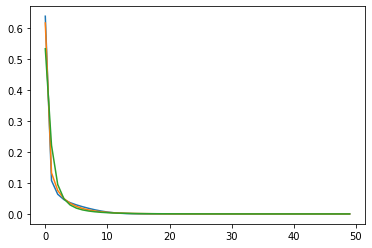

In [65]:
plt.plot(Pss_tele)
plt.plot(Pss_gou)
plt.plot(Pss_cir)

In [66]:
print((Pss_tele.sum(1)*x).sum())
print((Pss_gou.sum(1)*x).sum())
print((Pss_cir.sum(1)*x).sum())


1.2821620194235468
1.2819363588611037
1.2815231155669835


In [67]:
print((Pss_tele.sum(1)*x**2).sum() - (Pss_tele.sum(1)*x).sum()**2)
print((Pss_gou.sum(1)*x**2).sum() - (Pss_gou.sum(1)*x).sum()**2)
print((Pss_cir.sum(1)*x**2).sum() - (Pss_cir.sum(1)*x).sum()**2)


5.644168303375134
6.40957606706649
6.3856863614744865


Somewhat obviously these distributions have different statistics..

### Sampling and evaluation

In [373]:
def sample_from_p(num_data_points, Pss):
    mx = Pss.shape
    p_flat = Pss.flatten()
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = np.random.choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M

def get_logL_1d(d,x,y,K_avg,beta,xyfun,model,mx):
    mx_eval = [mx[0],1]
    pars = xyfun(x,y,K_avg,beta)
    Pss = model.get_Pss(*pars,1,mx_eval)
    Pss = Pss.squeeze()
    logL = np.sum(np.log(Pss[d]))
    return logL


def get_logL_2d(d0,d1,x,y,K_avg,beta,gamma,xyfun,model,mx):
    mx_eval = mx
    pars = xyfun(x,y,K_avg,beta,gamma)
    Pss = model.get_Pss(*pars,mx_eval)
    Pss = Pss.squeeze()
    logL = np.sum(np.log(Pss[d0,d1]))
    return logL

# Parameter regimes

In [772]:
kappa = 0.1
beta = 0.8 
gamma = 0.9
theta = 1
a = 0.4
mx = [50,51]

In [773]:
gou_model = GOUModel()
Pss_gou_true = gou_model.get_Pss(a,kappa,theta,beta,gamma,mx)


In [774]:
xtrue1,ytrue1,K_avg,beta = encode_xy_sde_1d(a, kappa, theta,beta)
xtrue2,ytrue2,K_avg,beta,gamma = encode_xy_sde_2d(a, kappa, theta,beta,gamma)

In [775]:
nCells = 200
nTrials = 50
num_data_points = (nCells,nTrials)

In [776]:
K_avg

4.0

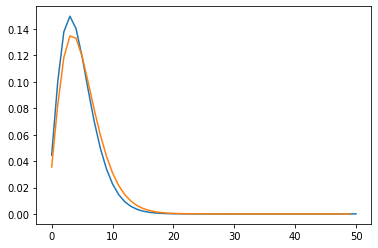

In [777]:
plt.plot(Pss_gou_true.sum(0))
plt.plot(Pss_gou_true.sum(1))

In [778]:
data = sample_from_p(num_data_points,Pss_gou_true)

In [779]:
Pss_gou_true.shape

(50, 51)

In [780]:
# decode_xy_sde_2d(x,y,K_avg,beta,gamma)

In [781]:
# mx_eval = mx
# pars = decode_xy_sde_2d(x,y,K_avg,beta,gamma)
# Pss = gou_model.get_Pss(*pars,mx_eval)
# Pss = Pss.squeeze()


In [782]:
# Pss[data[0][:,0],data[1][:,1]].shape

In [783]:
# logL = np.sum(np.log(Pss[d0][:,d1]))


In [784]:
# get_logL_1d(data[0][:,0],x,y,K_avg,beta,decode_xy_sde_1d,gou_model,mx)

In [785]:
# get_logL_2d(data[0][:,0],data[1][:,0],x,y,K_avg,beta,gamma,decode_xy_sde_2d,gou_model,mx)

In [860]:
nX = 14
nY = 15
x_ = np.linspace(0.01,0.99,nX)
y_ = np.linspace(0.01,0.99,nY)
X,Y = np.meshgrid(x_,y_,indexing='ij')
logL_1d = np.zeros((nX,nY))
logL_2d = np.zeros((nX,nY))
for i,x in enumerate(x_):
    for j,y in enumerate(y_):
        logL_1d[i,j] = get_logL_1d(data[0][:,0],x,y,K_avg,beta,decode_xy_sde_1d,gou_model,mx)
        logL_2d[i,j] = get_logL_2d(data[0][:,0],data[1][:,0],x,y,K_avg,beta,gamma,decode_xy_sde_2d,gou_model,mx)

In [861]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap

# c1 = [0,0,0,0]
# # c2 = [1,1,1,1]
# c2 = [235/255,228/255,143/255,1]
# ncol=2
# cmap_highlight = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(4)]).T)
colors = [(1,0,0,c) for c in np.linspace(0,1,100)]
cmap_highlight = LinearSegmentedColormap.from_list('mycmap', colors, N=5)

cmap_logl = 'cividis'
# color_highlight = cmap_highlight
fs = 12

In [862]:
colors_transp = [(1,1,1,c) for c in np.linspace(1,1,100)]
cmap_highlight = LinearSegmentedColormap.from_list('mycmap', colors_transp, N=5)


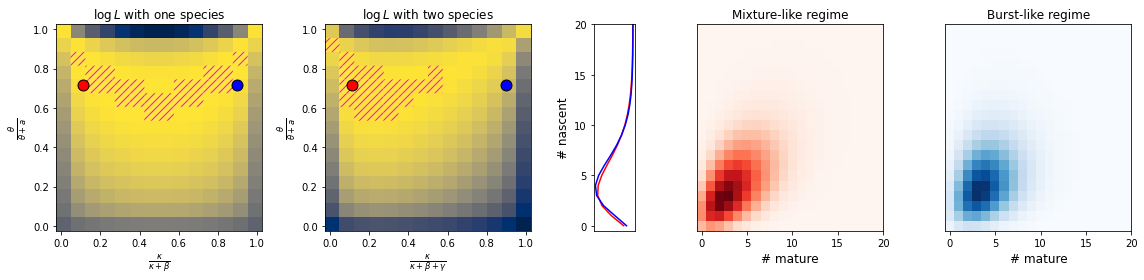

In [863]:
fig1,ax1 = plt.subplots(1,5,figsize=(16,4),gridspec_kw={'width_ratios': [1,1,0.2,0.9,0.9]})

ax1[0].pcolormesh(X,Y,(logL_1d),cmap=cmap_logl)
q = np.quantile(logL_1d,0.9)
ax1[0].pcolor(X,Y,np.ma.masked_array(logL_1d,logL_1d<q),
              cmap=cmap_logl,
              alpha=1,hatch='///',edgecolor='magenta',facecolor=None,linewidth=0,
              vmin=vmin,vmax=vmax)
# ax1[0].pcolormesh(X,Y,np.ma.masked_array(logL_1d,logL_1d<q),cmap=cmap_highlight,alpha=0.5)
ax1[0].scatter(xtrue1,ytrue1,120,'r',edgecolors='k')

xfalse1 = 0.9
yfalse1 = ytrue1
ax1[0].scatter(xfalse1,yfalse1,120,'b',edgecolors='k')
ax1[0].set_title(r'$\log L$ with one species',fontsize=fs)
ax1[0].set_xlabel(r'$\frac{\kappa}{\kappa + \beta}$',fontsize=fs)
ax1[0].set_ylabel(r'$\frac{\theta}{\theta + a}$',fontsize=fs)


vmin,vmax = (logL_2d.min(),logL_2d.max())
ax1[1].pcolormesh(X,Y,(logL_2d),cmap=cmap_logl,vmin=vmin,vmax=vmax)
q = np.quantile(logL_2d,0.9)
ax1[1].pcolor(X,Y,np.ma.masked_array(logL_2d,logL_2d<q),
              cmap=cmap_logl,
              alpha=1,hatch='///',edgecolor='magenta',facecolor=None,linewidth=0,
              vmin=vmin,vmax=vmax)
ax1[1].scatter(xtrue2,ytrue2,120,'r',edgecolors='k')
ax1[1].scatter(xfalse1,yfalse1,120,'b',edgecolors='k')
ax1[1].set_title(r'$\log L$ with two species',fontsize=fs)
ax1[1].set_xlabel(r'$\frac{\kappa}{\kappa + \beta + \gamma}$',fontsize=fs)
ax1[1].set_ylabel(r'$\frac{\theta}{\theta + a}$',fontsize=fs)

Pss_gou_false = gou_model.get_Pss(*decode_xy_sde_2d(xfalse1,yfalse1,K_avg,beta,gamma),mx)

xvals = np.arange(mx[0])
Pvals_true = Pss_gou_true.sum(1)
Pvals_false = Pss_gou_false.sum(1)

ax1[2].plot(Pvals_true,xvals,'r')
ax1[2].plot(Pvals_false,xvals,'b')
ax1[2].invert_xaxis()
ax1[2].set_xticks([])
ax1[2].set_yticks(np.arange(0,21,5))
ax1[2].set_ylabel('# nascent',fontsize=fs)


ax1[3].imshow((Pss_gou_true),cmap='Reds',aspect='auto')
ax1[3].invert_yaxis()
ax1[3].set_yticks([])
ax1[3].set_xlabel('# mature',fontsize=fs)
ax1[3].set_title('Mixture-like regime',fontsize=fs)


ax1[4].imshow((Pss_gou_false),cmap='Blues',aspect='auto')
ax1[4].invert_yaxis()
ax1[4].set_yticks([])
ax1[4].set_xlabel('# mature',fontsize=fs)
ax1[4].set_title('Burst-like regime',fontsize=fs)


lims = [-0.5,20]
ax1[2].set_ylim(lims)
ax1[3].set_ylim(lims)
ax1[4].set_ylim(lims)
ax1[3].set_xlim(lims)
ax1[4].set_xlim(lims)

fig1.tight_layout()


In [851]:
# ax1[1].gci().get_clim()

# AIC

In [889]:
import warnings
warnings.filterwarnings("error")


In [908]:
nCells = 200
nTrials = 1
num_data_points = (nCells,nTrials)
telegraph_model = TelegraphModel()
gou_model = GOUModel()
cir_model = CIRModel()
models = [gou_model, cir_model, telegraph_model]
decode_fun_1d = [decode_xy_sde_1d,decode_xy_sde_1d,decode_xy_tele_1d]
true_model = models[0]


In [ ]:
nX = 4
nY = 5
x_ = np.linspace(0.01,0.99,nX)
y_ = np.linspace(0.01,0.99,nY)
nmod = 3
X,Y = np.meshgrid(x_,y_,indexing='ij')
logL_1d_AIC = np.zeros((nX,nY,nmod,nTrials))
# logL_2d = np.zeros((nX,nY))
for i,x in enumerate(x_):
    print(i)
    for j,y in enumerate(y_):
        Pss_true = true_model.get_Pss(*decode_xy_sde_1d(x,y,K_avg,beta),1,[mx[0],1])
        data = sample_from_p(num_data_points,Pss_true)
        for k in range(nmod):
            for trial in range(nTrials):
                logL_1d_AIC[i,j,k,trial] = get_logL_1d(data[0][:,trial],x,y,K_avg,beta,decode_fun_1d[k],models[k],mx)

0


In [871]:
gamma

0.9

In [758]:
AIC_values = -2*logL_1d_AIC 

In [759]:
AICmin = np.amin(AIC_values,2)
dAIC = AIC_values-AICmin[:,:,None,:]

In [760]:
AIC = np.exp(-dAIC/2)
AIC /= AIC.sum(2)[:,:,None,:]

In [761]:
AIC.shape

(10, 12, 2, 15)

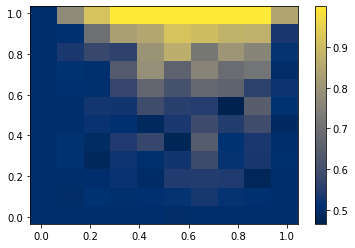

In [762]:
plt.pcolormesh(X,Y,AIC[:,:,0].mean(-1),cmap=cmap_logl)
plt.colorbar()


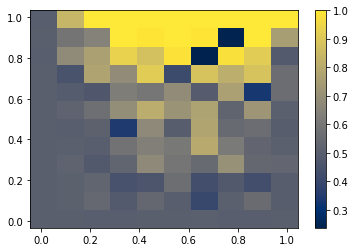

In [763]:
plt.pcolormesh(X,Y,AIC[:,:,0,2],cmap=cmap_logl)
plt.colorbar()


In [747]:
AIC[:,:,0].shape

(10, 12, 5)

In [638]:
logL_1d_aic

array([[[-434.34939094, -434.34960938, -434.03882046],
        [-467.71963518, -467.71887207, -470.74803817],
        [-471.57730682, -471.57446289, -476.0049019 ],
        [-471.244481  , -471.25036621, -475.39835684],
        [-521.94050001, -521.93005371,           nan]],

       [[-434.83773069, -434.83691406, -434.32330716],
        [-471.94839214, -471.76126099,           nan],
        [-492.69814522, -492.79272461, -507.25697738],
        [-504.32982011, -504.33233643,           nan],
        [-520.02599986, -525.64904785,           nan]],

       [[-464.96161496, -464.9876709 , -466.57081779],
        [-489.24405276, -489.35629272, -501.30698796],
        [-511.62121794, -512.41894531,           nan],
        [-516.29209976, -518.14154053,           nan],
        [-500.86956447, -516.71868896, -518.38700682]],

       [[-444.72338345, -444.68670654, -445.01098868],
        [-458.61799464, -458.644104  , -453.49798827],
        [-498.20916952, -497.60095215, -513.84058382],
    

In [489]:
decode_xy_sde_1d(x,y,K_avg,beta)

(1.788854381999832, 0.008080808080808083, 0.018069236181816484, 0.8)

In [491]:
gou_model.get_Pss?

In [635]:
logL_1d_aic

array([[[-434.34939094, -434.34960938, -434.03882046],
        [-467.71963518, -467.71887207, -470.74803817],
        [-471.57730682, -471.57446289, -476.0049019 ],
        [-471.244481  , -471.25036621, -475.39835684],
        [-521.94050001, -521.93005371,           nan]],

       [[-434.83773069, -434.83691406, -434.32330716],
        [-471.94839214, -471.76126099,           nan],
        [-492.69814522, -492.79272461, -507.25697738],
        [-504.32982011, -504.33233643,           nan],
        [-520.02599986, -525.64904785,           nan]],

       [[-464.96161496, -464.9876709 , -466.57081779],
        [-489.24405276, -489.35629272, -501.30698796],
        [-511.62121794, -512.41894531,           nan],
        [-516.29209976, -518.14154053,           nan],
        [-500.86956447, -516.71868896, -518.38700682]],

       [[-444.72338345, -444.68670654, -445.01098868],
        [-458.61799464, -458.644104  , -453.49798827],
        [-498.20916952, -497.60095215, -513.84058382],
    

In [615]:
get_logL_1d(data[0][:,0],x,y,K_avg,beta,decode_fun_1d[k],models[k],mx)


KeyboardInterrupt: 

In [617]:
mx_eval = [mx[0],1]
pars = decode_fun_1d[k](x,y,K_avg,beta)


In [618]:
pars

(0.00808064318990182, 1.6489090626237157e-07, 4.000081622664131, 0.8)

In [620]:
# mx_eval

In [631]:
Pss = models[k].get_Pss(*pars,1,mx_eval)
# Pss = Pss.squeeze()
# logL = np.sum(np.log(Pss[d]))


/tmp/ipykernel_122659/3833912903.py:96: RuntimeWarning: overflow encountered in exp
  Ufun = (np.exp(L*x)@coeff)
/tmp/ipykernel_122659/3833912903.py:96: RuntimeWarning: invalid value encountered in matmul
  Ufun = (np.exp(L*x)@coeff)


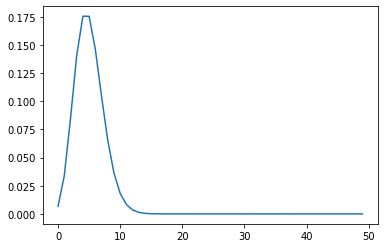

In [633]:
plt.plot(Pss)